In [66]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

In [67]:
from pathlib import Path
import numpy as np
import plotly.express as px
import re
from dataclasses import dataclass
import pandas as pd
import subprocess

MAX_FILES = None
FREQ_GRID = np.geomspace(20, 20000, 1000)

In [68]:
pip install --upgrade kaleido

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [69]:
from pathlib import Path
import subprocess

AUTOEQ_REPO_DIR = Path("../../datasets/autoeq")
AUTOEQ_RESULTS = AUTOEQ_REPO_DIR / "results"

# Клонируем или обновляем
if not AUTOEQ_REPO_DIR.exists():
    AUTOEQ_REPO_DIR.parent.mkdir(parents=True, exist_ok=True)
    subprocess.run(
        ["git", "clone", "https://github.com/jaakkopasanen/AutoEq.git", str(AUTOEQ_REPO_DIR)],
        check=True
    )
else:
    subprocess.run(["git", "-C", str(AUTOEQ_REPO_DIR), "pull"], check=True)

# Проверки
print("AUTOEQ_REPO_DIR:", AUTOEQ_REPO_DIR.resolve())
print("AUTOEQ_RESULTS:", AUTOEQ_RESULTS.resolve())
assert AUTOEQ_RESULTS.exists(), f"results not found at {AUTOEQ_RESULTS.resolve()}"

AUTOEQ_REPO_DIR: C:\Users\makcc\PycharmProjects\EarLoop\datasets\autoeq
AUTOEQ_RESULTS: C:\Users\makcc\PycharmProjects\EarLoop\datasets\autoeq\results


In [70]:
# ========== PARSING ==========
@dataclass
class PEQFilter:
    ftype: str          # "PK", "LS", "HS", "NOTCH" (если встретится)
    fc_hz: float
    q: float | None
    gain_db: float | None
    source_file: str

# EqualizerAPO / AutoEq обычно пишет строки вида:
# Filter 1: ON PK Fc 105 Hz Gain -2.3 dB Q 1.41
# Filter 2: ON LS Fc 60 Hz Gain 5.0 dB Q 0.71
filter_re = re.compile(
    r"Filter\s+\d+:\s+ON\s+"
    r"(?P<type>[A-Z]+)\s+Fc\s+(?P<fc>[\d.]+)\s*Hz"
    r"(?:\s+Gain\s+(?P<gain>[-+]?[\d.]+)\s*dB)?"
    r"(?:\s+Q\s+(?P<q>[\d.]+))?",
    re.IGNORECASE
)

def parse_parametric_eq_file(path: Path) -> list[PEQFilter]:
    filters: list[PEQFilter] = []
    text = path.read_text(encoding="utf-8", errors="ignore")
    for m in filter_re.finditer(text):
        ftype = m.group("type").upper()
        fc = float(m.group("fc"))
        gain = m.group("gain")
        q = m.group("q")
        filters.append(
            PEQFilter(
                ftype=ftype,
                fc_hz=fc,
                gain_db=float(gain) if gain is not None else None,
                q=float(q) if q is not None else None,
                source_file=str(path),
            )
        )
    return filters

files = list(AUTOEQ_RESULTS.rglob("*ParametricEQ*.txt"))
if MAX_FILES:
    files = files[:MAX_FILES]

print("Found files:", len(files))
print("Example:", files[0] if files else None)

all_filters: list[PEQFilter] = []
for f in files:
    all_filters.extend(parse_parametric_eq_file(f))

df = pd.DataFrame([vars(x) for x in all_filters])
df.head(), df.shape

type_map = {
    "LSC": "LS",
    "HSC": "HS",
    "PK": "PK",
}

df["ftype"] = df["ftype"].astype(str).str.upper().map(lambda x: type_map.get(x, x))
df["model_id"] = df["source_file"].astype(str)

df.head(), df.shape

Found files: 8850
Example: ..\..\datasets\autoeq\results\Auriculares Argentina\in-ear\7Hz Salnotes Zero\7Hz Salnotes Zero ParametricEQ.txt


(  ftype   fc_hz     q  gain_db  \
 0    LS   105.0  0.70      2.6   
 1    PK  6337.0  3.61      5.3   
 2    PK   210.0  1.03     -1.0   
 3    PK  4135.0  2.06     -1.4   
 4    PK  1370.0  2.36     -1.0   
 
                                          source_file  \
 0  ..\..\datasets\autoeq\results\Auriculares Arge...   
 1  ..\..\datasets\autoeq\results\Auriculares Arge...   
 2  ..\..\datasets\autoeq\results\Auriculares Arge...   
 3  ..\..\datasets\autoeq\results\Auriculares Arge...   
 4  ..\..\datasets\autoeq\results\Auriculares Arge...   
 
                                             model_id  
 0  ..\..\datasets\autoeq\results\Auriculares Arge...  
 1  ..\..\datasets\autoeq\results\Auriculares Arge...  
 2  ..\..\datasets\autoeq\results\Auriculares Arge...  
 3  ..\..\datasets\autoeq\results\Auriculares Arge...  
 4  ..\..\datasets\autoeq\results\Auriculares Arge...  ,
 (88500, 6))

In [71]:
from pathlib import PureWindowsPath

autoeq_df = df.copy()

autoeq_df["model"] = autoeq_df["source_file"].apply(
    lambda p: PureWindowsPath(p).parts[-2]
)

def extract_category(p):
    parts = PureWindowsPath(p).parts
    if "results" in parts:
        return parts[6]
    return None

autoeq_df["category"] = autoeq_df["source_file"].apply(extract_category)

def extract_vendor(p):
    parts = PureWindowsPath(p).parts
    if "results" in parts:
        return parts[5]
    return None

autoeq_df["vendor"] = autoeq_df["source_file"].apply(extract_vendor)

# 4) Собираем финальную таблицу
out = autoeq_df[["vendor", "category", "model", "ftype", "fc_hz", "q", "gain_db"]].copy()

SAVE_PATH = Path("../../datasets/autoeq_analysis")
SAVE_PATH.mkdir(parents=True, exist_ok=True)

out.to_csv(SAVE_PATH / "autoeq_parametric_eq_clean.csv", index=False)
print(out.shape)
out.head()

(88500, 7)


,vendor,category,model,ftype,fc_hz,q,gain_db
0,Auriculares Argentina,in-ear,7Hz Salnotes Zero,LS,105.0,0.70,2.6
1,Auriculares Argentina,in-ear,7Hz Salnotes Zero,PK,6337.0,3.61,5.3
2,Auriculares Argentina,in-ear,7Hz Salnotes Zero,PK,210.0,1.03,-1.0
3,Auriculares Argentina,in-ear,7Hz Salnotes Zero,PK,4135.0,2.06,-1.4
4,Auriculares Argentina,in-ear,7Hz Salnotes Zero,PK,1370.0,2.36,-1.0


In [72]:
out

,vendor,category,model,ftype,fc_hz,q,gain_db
0,Auriculares Argentina,in-ear,7Hz Salnotes Zero,LS,105.0,0.70,2.6
1,Auriculares Argentina,in-ear,7Hz Salnotes Zero,PK,6337.0,3.61,5.3
2,Auriculares Argentina,in-ear,7Hz Salnotes Zero,PK,210.0,1.03,-1.0
3,Auriculares Argentina,in-ear,7Hz Salnotes Zero,PK,4135.0,2.06,-1.4
4,Auriculares Argentina,in-ear,7Hz Salnotes Zero,PK,1370.0,2.36,-1.0
...,...,...,...,...,...,...,...
88495,ToneDeafMonk,in-ear,ZiiGaat x Fresh Reviews Arete,HS,10000.0,0.70,-4.9
88496,ToneDeafMonk,in-ear,ZiiGaat x Fresh Reviews Arete,PK,8576.0,1.53,1.7
88497,ToneDeafMonk,in-ear,ZiiGaat x Fresh Reviews Arete,PK,709.0,3.04,0.7
88498,ToneDeafMonk,in-ear,ZiiGaat x Fresh Reviews Arete,PK,4635.0,5.91,-1.8


In [73]:
print("max fc:", df["fc_hz"].max())
print(df[df["fc_hz"] > 10000][["ftype","fc_hz","gain_db","q","source_file"]].head(10))

max fc: 10000.0
Empty DataFrame
Columns: [ftype, fc_hz, gain_db, q, source_file]
Index: []


In [74]:
df["ftype"].unique()

array(['LS', 'PK', 'HS'], dtype=object)

In [75]:
import plotly.io as pio
pio.templates.default = "plotly_white"

COMMON_LAYOUT = dict(
    width=1100, height=420,
    margin=dict(l=60, r=30, t=60, b=55),
    font=dict(size=16),
)
OUTPUT_PLOT = Path("./reports/figures")
OUTPUT_PLOT.mkdir(parents=True, exist_ok=True)

Resorting to unclean kill browser.


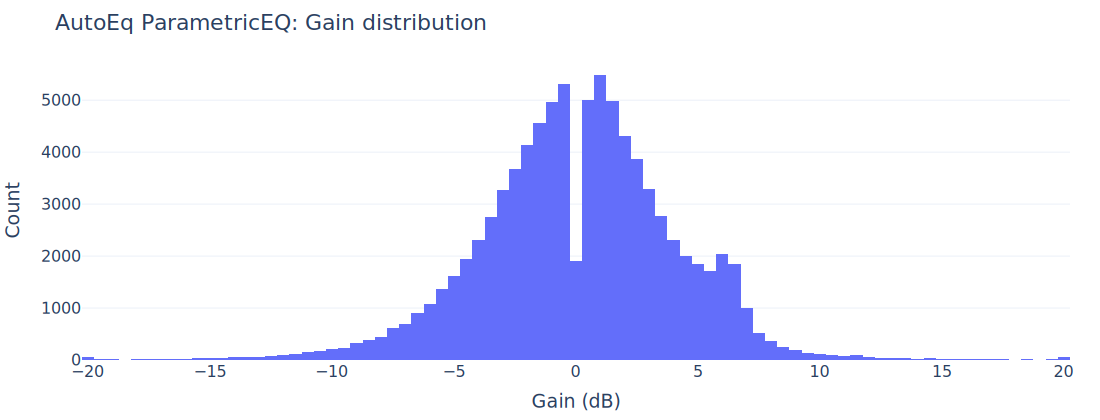

In [76]:
import plotly.express as px

dg = df.dropna(subset=["gain_db"])

fig = px.histogram(
    dg, x="gain_db",
    nbins=120,
    title="AutoEq ParametricEQ: Gain distribution"
)
fig.update_layout(**COMMON_LAYOUT)
fig.update_xaxes(title="Gain (dB)", zeroline=False)
fig.update_yaxes(title="Count", zeroline=False)
fig.show(renderer="svg")
fig.write_image(OUTPUT_PLOT / "Gain distribution.png", scale=2)

### Распределение коэффициентов усиления (gain, dB)

Распределение коэффициентов усиления параметрических EQ-фильтров AutoEq является симметричным и центрированным вокруг 0 dB.
Это указывает на то, что глобальный тональный баланс большинства моделей наушников близок к целевому, а эквализация в основном вносит **умеренные корректировки**, а не радикальные изменения звучания.

Основная масса значений сосредоточена в диапазоне **−6 … +6 dB**, который можно рассматривать как *нормальную зону коррекций*:

$$
\text{gain} \in [-6,\ +6]\ \text{dB}
$$

Наблюдаемые экстремальные значения (до ±15–20 dB) встречаются редко и обусловлены отдельными проблемными моделями либо узкополосными резонансами. Эти случаи не определяют типичное поведение системы и могут рассматриваться как выбросы.

Важно отметить, что использование равномерного распределения

$$
\text{gain} \sim \mathcal{U}(-20,\ 20)
$$

для генерации синтетических пользователей является нереалистичным: более 95% эмпирических коррекций AutoEq располагаются значительно ближе к нулю.

В связи с этим в работе используется **эмпирическое априорное распределение параметров усиления**, извлечённое из AutoEq, что позволяет формировать статистически и акустически правдоподобные синтетические профили пользователей.


In [77]:
import pandas as pd

d = df.copy()
d["ftype"] = d["ftype"].astype(str).str.upper().str.strip()
d["fc_hz"] = pd.to_numeric(d["fc_hz"], errors="coerce")
d["gain_db"] = pd.to_numeric(d["gain_db"], errors="coerce")

d = d.dropna(subset=["ftype", "fc_hz"])

fc_ranges = (
    d.groupby("ftype")["fc_hz"]
     .agg(["count", "min", "max", "median"])
     .sort_index()
)

fc_ranges

,count,min,max,median
ftype,,,,
HS,8850,10000.0,10000.0,10000.0
LS,8850,105.0,105.0,105.0
PK,70800,20.0,10000.0,2000.0


### Диапазоны центральных частот по типам фильтров

Анализ распределения центральных частот показал, что shelving-фильтры имеют фиксированные значения Fc: для низкочастотного shelving-фильтра (LS) Fc = 105 Гц, а для высокочастотного shelving-фильтра (HS) Fc = 10 кГц. Эти фильтры присутствуют в каждой конфигурации AutoEq и используются для задания глобального тонального баланса.

В отличие от них, peaking-фильтры (PK) распределены по широкому диапазону частот (20 Гц – 10 кГц) с медианным значением около 2 кГц, что отражает их роль в компенсации локальных резонансов и провалов частотной характеристики. В связи с этим дальнейший анализ частотных зон и характера коррекций проводится преимущественно на основе PK-фильтров.

In [78]:
import numpy as np
import pandas as pd

d = df.copy()
d["ftype"] = d["ftype"].astype(str).str.upper().str.strip()
d["fc_hz"] = pd.to_numeric(d["fc_hz"], errors="coerce")
d["gain_db"] = pd.to_numeric(d["gain_db"], errors="coerce")
d["q"] = pd.to_numeric(d.get("q", np.nan), errors="coerce")

d = d.dropna(subset=["ftype", "fc_hz", "gain_db"])
d = d[(d["fc_hz"] >= 20) & (d["fc_hz"] <= 10000)]

pk = d[d["ftype"] == "PK"].copy()
print("PK rows:", len(pk), " / unique models approx:", pk.get("model_id", pd.Series(dtype=str)).nunique())


PK rows: 70800  / unique models approx: 8850


In [79]:
import plotly.graph_objects  as go

def boost_cut_band_pk(pk_df, lo, hi, bins_n=80, title=""):
    x = pk_df[(pk_df["fc_hz"] >= lo) & (pk_df["fc_hz"] <= hi)].copy()
    if len(x) == 0:
        print("Empty band:", lo, hi); return

    pos = x[x["gain_db"] > 0]
    neg = x[x["gain_db"] < 0]

    bins = np.geomspace(lo, hi, bins_n)
    pos_w, edges = np.histogram(pos["fc_hz"].values, bins=bins, weights=pos["gain_db"].values)
    neg_w, _     = np.histogram(neg["fc_hz"].values, bins=bins, weights=np.abs(neg["gain_db"].values))
    centers = np.sqrt(edges[:-1] * edges[1:])

    fig = go.Figure()
    fig.add_bar(x=centers, y=pos_w, name="Boost (sum +gain)", opacity=0.75)
    fig.add_bar(x=centers, y=neg_w, name="Cut (sum |−gain|)", opacity=0.55)

    fig.update_layout(title=title, barmode="overlay", **COMMON_LAYOUT)
    fig.update_xaxes(type="log", title="Fc (Hz, log scale)")
    fig.update_yaxes(title="Sum of magnitudes (dB)")
    fig.show(renderer="svg")
    title = title.replace(":", "")
    fig.write_image(OUTPUT_PLOT / f"{title}.png", scale=2)

In [80]:
def find_band_splits_by_importance(pk_df, fmin=20, fmax=10000, nbins=200):
    freqs = pk_df["fc_hz"].values
    w = np.abs(pk_df["gain_db"].values)

    bins = np.geomspace(fmin, fmax, nbins)
    imp, edges = np.histogram(freqs, bins=bins, weights=w)
    centers = np.sqrt(edges[:-1] * edges[1:])

    cum = np.cumsum(imp)
    cum = cum / (cum[-1] if cum[-1] > 0 else 1)

    def at(q):
        idx = np.searchsorted(cum, q)
        idx = np.clip(idx, 0, len(centers)-1)
        return float(centers[idx])

    f1 = at(1/3)
    f2 = at(2/3)
    return f1, f2, centers, imp, cum

f1, f2, centers, imp, cum = find_band_splits_by_importance(pk)
print("Auto splits (by sum |gain|):", f1, f2)

Auto splits (by sum |gain|): 1039.2185923511086 4371.086707821906


## Разбиение частотного спектра на диапазоны

Для параметризации частотных предпочтений и анализа характера коррекций спектр был разбит на несколько диапазонов. Разбиение выполнялось автоматически на основе статистики peaking-фильтров (PK), что позволило избежать произвольного выбора границ и опереться на реальные данные AutoEq.

### Метод определения границ

В качестве меры значимости частоты использовалась суммарная величина коррекций peaking-фильтрами $$(|gain|\)$$. Частотная ось в диапазоне 20 Гц – 10 кГц была разбита на логарифмические интервалы, после чего для каждого интервала вычислялась суммарная величина коррекций. Далее была построена кумулятивная функция распределения, отражающая накопленную долю общей коррекции по мере роста частоты.

Границы диапазонов выбирались таким образом, чтобы каждая полоса содержала приблизительно одинаковую долю общей коррекции. В результате были получены следующие границы:
- **20–1039 Гц**
- **1039–4371 Гц**
- **4371–10000 Гц**

---

### Обоснование количества диапазонов

Использование трёх диапазонов обусловлено как статистическими, так и психоакустическими факторами.

С точки зрения данных AutoEq, разбиение на три диапазона является минимальным, при котором сохраняется структурная неоднородность коррекций. При меньшем числе диапазонов (один или два) существенно различаются по характеру зоны спектра объединялись бы в одну, что приводило бы к потере информации. При большем числе диапазонов корреляция между соседними полосами возрастала бы, а интерпретируемость параметров снижалась.

С точки зрения психоакустики, три диапазона соответствуют функционально различным областям восприятия:
- нижний диапазон связан преимущественно с энергетическим балансом и резонансами (бас и нижняя середина),
- средний диапазон определяет разборчивость и субъективное восприятие присутствия,
- верхний диапазон отвечает за детализацию, атаку и восприятие резкости.

Таким образом, использование трёх диапазонов обеспечивает компромисс между выразительностью модели и её простотой, позволяя описывать основные различия в характере коррекций без избыточного усложнения параметризации.

---

### Интерпретация полученных диапазонов

Несмотря на то, что численные значения автоматических границ не совпадают строго с традиционно используемыми частотными полосами, их функциональный смысл сохраняется. Нижняя граница около 1 кГц отделяет область преимущественно компенсирующих коррекций от зоны активной балансировки присутствия, а граница около 4.3 кГц отделяет область присутствия от высокочастотных коррекций, связанных с детализацией и контролем резкости.

Это подтверждает устойчивость выделенных частотных зон и обосновывает использование полученного разбиения при дальнейшем анализе и генерации параметров пользовательских предпочтений.


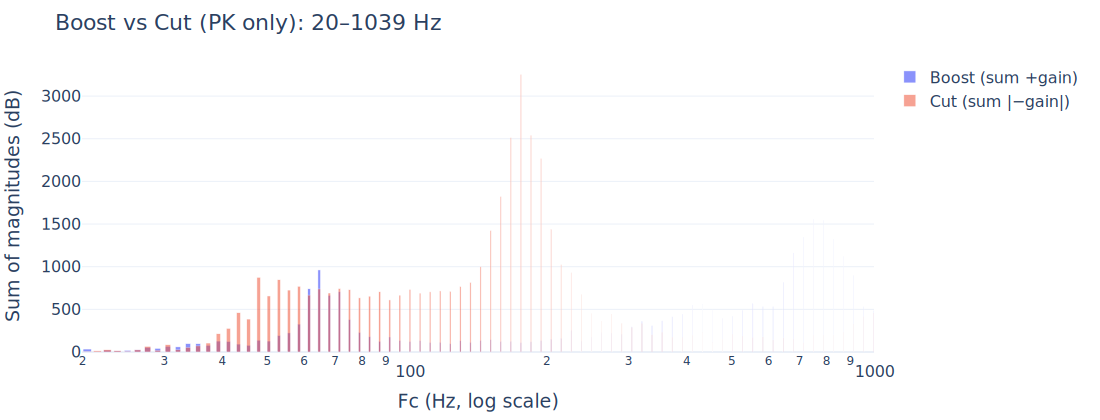

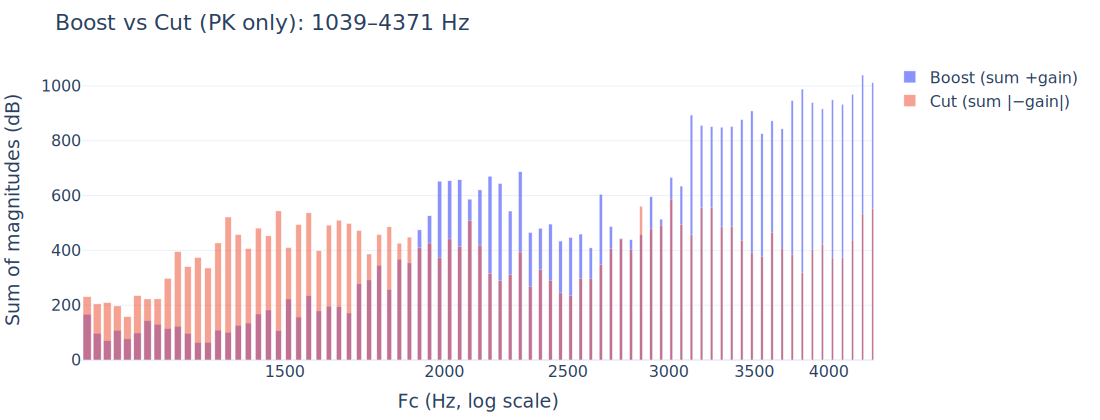

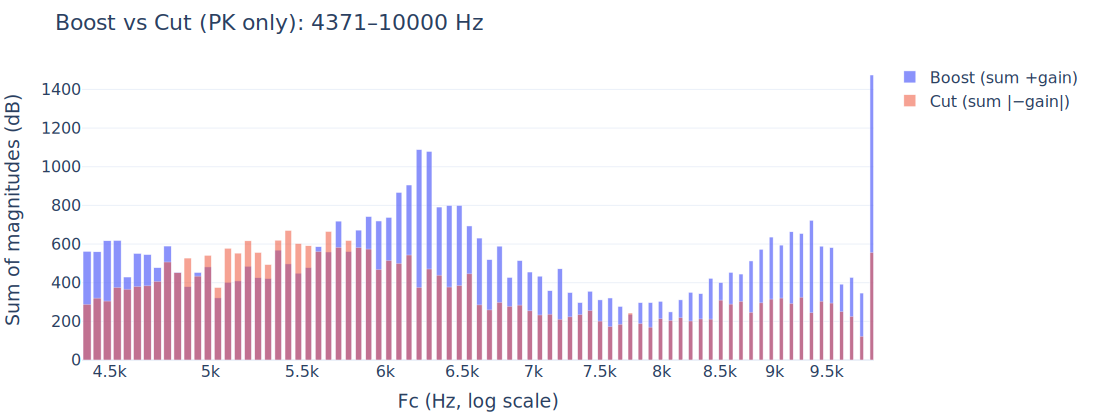

In [81]:
edges = [20, f1, f2, 10000]
boost_cut_band_pk(pk, edges[0], edges[1], title=f"Boost vs Cut (PK only): {edges[0]:.0f}–{edges[1]:.0f} Hz")
boost_cut_band_pk(pk, edges[1], edges[2], title=f"Boost vs Cut (PK only): {edges[1]:.0f}–{edges[2]:.0f} Hz")
boost_cut_band_pk(pk, edges[2], edges[3], title=f"Boost vs Cut (PK only): {edges[2]:.0f}–{edges[3]:.0f} Hz")

## Анализ частотных коррекций (PK-only)

Для анализа локальных частотных искажений использовались только peaking-фильтры (PK), поскольку в отличие от shelving-фильтров (LS и HS) они распределены по всему спектру и отражают частоты, на которых коррекция применяется выборочно. В качестве меры “важности” частоты использовалась суммарная величина коррекций \(|gain|\).

---

### Диапазон 20–1039 Гц

В нижнем диапазоне преобладают ослабления (cut), особенно в области приблизительно 80–300 Гц. Это указывает на типичную избыточность энергии в зоне mid-bass и нижней середины, связанную с резонансами корпуса наушников и особенностями посадки. Усиления (boost) встречаются значительно реже и имеют меньшую суммарную величину, а самый низкочастотный диапазон (<50 Гц) корректируется сравнительно редко.

Таким образом, peaking-фильтры в данном диапазоне используются преимущественно для подавления локальных резонансов, а не для субъективного усиления баса.

---

### Диапазон 1039–4371 Гц

Средний диапазон характеризуется наибольшей плотностью и вариативностью коррекций. В области около 1.2–1.6 кГц наблюдается концентрация ослаблений, тогда как в зоне примерно 1.8–2.5 кГц преобладают усиления. Это отражает необходимость тонкой балансировки области присутствия, критически важной для разборчивости речи и субъективного комфорта прослушивания.

Данный диапазон является наиболее чувствительным для слуха человека, что объясняет активное и разнонаправленное использование peaking-фильтров.

---

### Диапазон 4371–10000 Гц

В высокочастотной области коррекции характеризуются высокой вариативностью. Выраженный пик усилений наблюдается в зоне около 5.8–6.5 кГц, что связано с добавлением детализации и атаки. В диапазоне 7–9 кГц коррекции носят смешанный характер: одновременно встречаются как усиления, так и ослабления, направленные на контроль резкости и сибилянтов.

Индивидуальный характер коррекций в этом диапазоне указывает на сильную зависимость от конкретной модели наушников и особенностей их высокочастотных резонансов.


In [82]:
qdf = pk.dropna(subset=["q"]).copy()
qdf = qdf[qdf["q"] > 0]

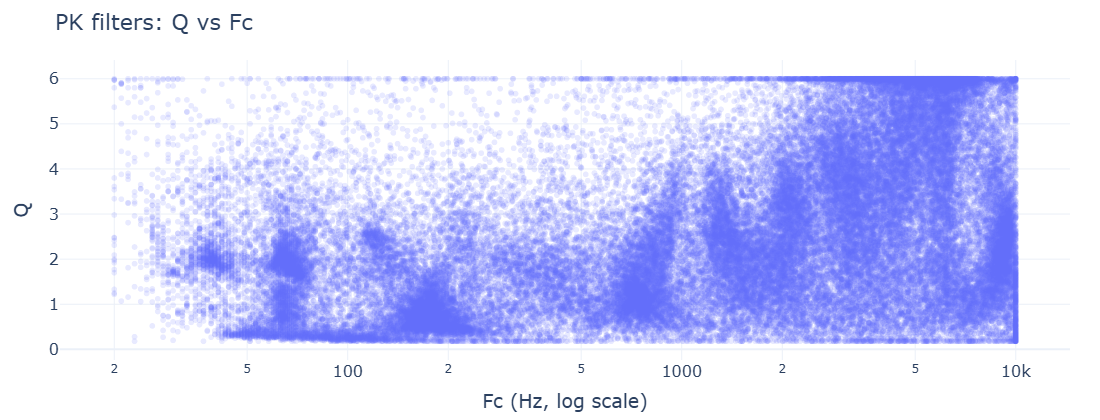

In [83]:
fig = px.scatter(
    qdf,
    x="fc_hz",
    y="q",
    opacity=0.15,
    title="PK filters: Q vs Fc"
)
fig.update_layout(**COMMON_LAYOUT)
fig.update_xaxes(type="log", title="Fc (Hz, log scale)")
fig.update_yaxes(title="Q")
fig.show(renderer="png")


In [84]:
bands = [
    (20, 1039, "Low"),
    (1039, 4371, "Mid"),
    (4371, 10000, "High")
]

rows = []
for lo, hi, name in bands:
    sub = qdf[(qdf["fc_hz"] >= lo) & (qdf["fc_hz"] < hi)]
    rows.append({
        "band": name,
        "count": len(sub),
        "q_median": sub["q"].median(),
        "q_p10": sub["q"].quantile(0.10),
        "q_p90": sub["q"].quantile(0.90),
    })

q_stats = pd.DataFrame(rows)
q_stats

,band,count,q_median,q_p10,q_p90
0,Low,27468,1.44,0.44,3.20
1,Mid,23053,2.88,0.98,5.51
2,High,19812,3.90,1.13,6.00


## Выводы по анализу параметра Q

Параметр Q (quality factor) характеризует ширину полосы коррекции peaking-фильтра и, тем самым, определяет масштаб спектрального воздействия эквалайзера. В отличие от центральной частоты и уровня усиления, которые задают положение и амплитуду коррекции, параметр Q отражает локальность изменения спектра и позволяет различать широкополосные и узкополосные коррекции.

Анализ распределения Q для peaking-фильтров показал выраженную зависимость ширины коррекций от частотного диапазона. В низкочастотной области преобладают сравнительно малые значения Q, соответствующие широкополосным коррекциям, направленным на компенсацию общей избыточной энергии и резонансов. В среднем диапазоне значения Q возрастают, что отражает необходимость более точной балансировки области присутствия. В высокочастотной области наблюдаются наибольшие значения Q, указывающие на преимущественно узкие и локальные коррекции, применяемые для подавления резких резонансов и сибилянтов.

Полученные результаты свидетельствуют о том, что параметр Q не является независимым пользовательским предпочтением, а определяется физической природой искажений в различных частотных зонах. В связи с этим параметр Q не включается непосредственно в вектор пользовательских предпочтений, а задаётся на этапе преобразования предпочтений в конкретную реализацию эквалайзерных фильтров, с учётом статистических характеристик AutoEq для соответствующих диапазонов частот.

Таким образом, анализ параметра Q дополняет анализ частот и уровней коррекции, позволяя описать не только направление и величину изменений спектра, но и характер их спектрального воздействия, что повышает реалистичность и интерпретируемость модели.


In [85]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# pk: DataFrame только PK, с числовыми fc_hz и gain_db
x = np.log10(pk["fc_hz"].values).reshape(-1, 1)

# веса: важность точки (можно |gain| или |gain|^p)
w = np.abs(pk["gain_db"].values)

def find_centers_kmeans(x, w, k, seed=42):
    km = KMeans(n_clusters=k, random_state=seed, n_init=10)
    km.fit(x, sample_weight=w)
    centers_log = np.sort(km.cluster_centers_.ravel())
    centers_hz = 10 ** centers_log
    return centers_hz

# попробуй несколько k, чтобы увидеть “естественные” зоны
for k in [5, 7, 9]:
    centers = find_centers_kmeans(x, w, k)
    print(k, np.round(centers).astype(int))


5 [  64  188  771 2450 6100]
7 [  64  184  667 1697 3162 5234 8126]
9 [  54   98  182  388  823 1810 3375 5532 8496]


## Вывод по выбору частотных зон и типам фильтров

В процессе анализа частотных коррекций было установлено, что различные типы эквалайзерных фильтров выполняют принципиально разные функции и, следовательно, должны учитываться различным образом при формировании параметрического пространства модели.

Shelving-фильтры (LS и HS) используются для задания глобального тонального баланса и имеют фиксированные центральные частоты. В частности, в конфигурациях AutoEq низкочастотная полка (LS) всегда располагается на частоте около 105 Гц, а высокочастотная полка (HS) — на частоте 10 кГц. Эти фильтры присутствуют в каждой модели и не отражают локальные частотные особенности, а потому не являются подходящими кандидатами для автоматического выделения зон коррекции.

В отличие от них, peaking-фильтры (PK) распределены по широкому диапазону частот и применяются выборочно для компенсации локальных резонансов и провалов. В связи с этим именно PK-фильтры были использованы для выявления характерных частотных зон с помощью кластеризации по логарифмической шкале частот с использованием величины коррекции в качестве веса.

Результаты кластеризации показали наличие устойчивых центров частотных зон, которые хорошо согласуются с практическим пользовательским опытом настройки эквалайзера и отражают частоты, наиболее часто подвергающиеся коррекции. Полученные зоны используются для формирования набора параметров локальной коррекции, тогда как shelving-фильтры добавляются в модель в виде фиксированных «якорных» элементов, задающих общий наклон спектра.

Таким образом, итоговая архитектура эквалайзера включает два уровня управления: глобальные параметры тонального баланса, реализуемые с помощью shelving-фильтров, и набор локальных параметров коррекции, определяемых статистикой peaking-фильтров. Такой подход позволяет совместить интерпретируемость модели, соответствие реальным пользовательским действиям и устойчивость параметризации.
